In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from pandas import concat
import numpy as np
from math import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from matplotlib import colors
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Loading Data

In [2]:
col_names = ["Date", "Sales"]
dateparse = lambda dates: pd.datetime.strptime(dates, '%d/%m/%Y')
df = pd.read_csv("USA_Monthly_Retail_And_Food Services_Sales.csv", 
                 names = col_names, header = 0, parse_dates = ['Date'],date_parser=dateparse)
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)
df = df.set_index(['Date'])
df.head()

,Sales
Date,
1992-01-01,146376
1992-02-01,147079
1992-03-01,159336
1992-04-01,163669
1992-05-01,170068


### Rolling Statistics

The first thing to do in any data analysis task is to plot the data. Graphs enable many features of the data to be visualised, including patterns, unusual observations, changes over time, and relationships between variables. The features that are seen in plots of the data must then be incorporated, as much as possible, into the forecasting methods to be used.

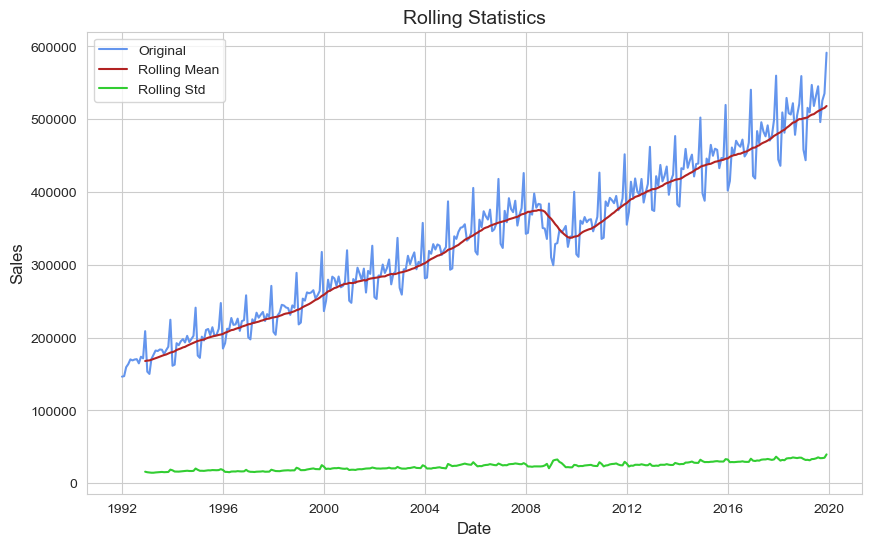

In [3]:
rolling_mean = df.rolling(window=12).mean()
rolling_std = df.rolling(window=12).std()
plt.figure(figsize = (10,6))
plt.plot(df, color='cornflowerblue', label='Original')
plt.plot(rolling_mean, color='firebrick', label='Rolling Mean')
plt.plot(rolling_std, color='limegreen', label='Rolling Std')
plt.xlabel('Date', size = 12)
plt.ylabel('Sales', size  = 12)
plt.legend(loc = 'upper left')
plt.title('Rolling Statistics', size = 14)
plt.show()

### Checking Stationarity

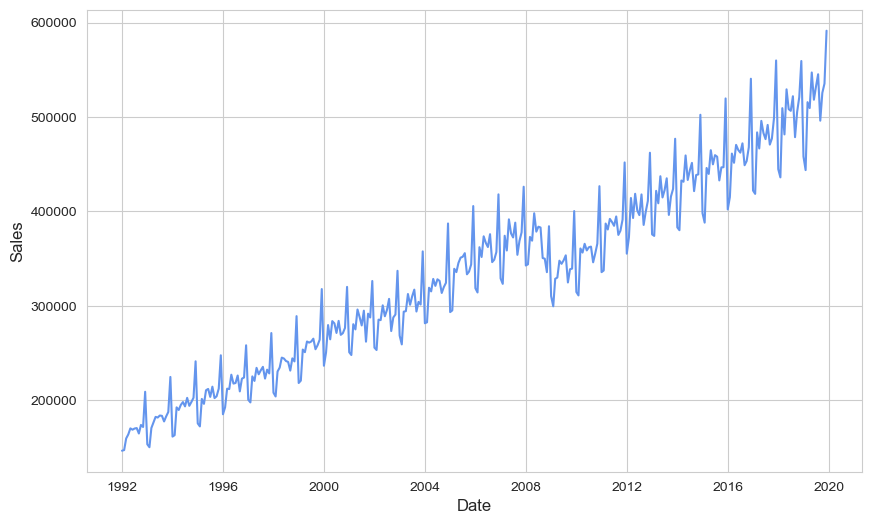

In [4]:
plt.figure(figsize = (10,6))
plt.plot(df['Sales'], color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Sales', size = 12)
plt.show()

Looking at the plot we can observe there is an upward trend over the period of time.

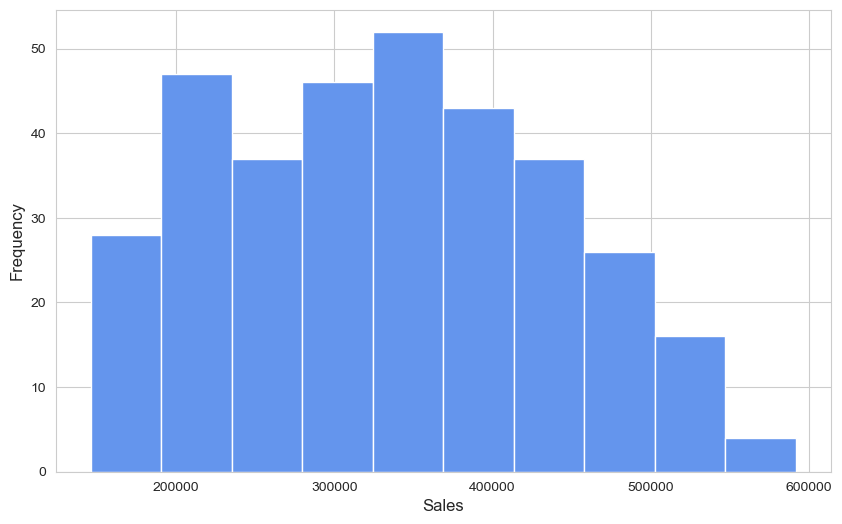

In [5]:
plt.figure(figsize = (10,6))
plt.hist(df['Sales'], color = 'cornflowerblue')
plt.xlabel('Sales', size = 12)
plt.ylabel('Frequency', size = 12)
plt.show()

In [6]:
print("Data Shape: {}".format(df.shape))
value_1 = df[0:168]
value_2 = df[169:336]

Data Shape: (336, 1)


Proceed by splitting the data into two parts so that we can then check the mean and variance of the data.

### Mean of Data

In [7]:
print("Mean of value_1: {}".format(round(value_1.mean()[0],3)))
print("Mean of value_2: {}".format(round(value_2.mean()[0],3)))

Mean of value_1: 249334.875
Mean of value_2: 416902.928


### Variance of Data

In [8]:
print("Variance of value_1: {}".format(round(value_1.var()[0],3)))
print("Variance of value_2: {}".format(round(value_2.var()[0],3)))

Variance of value_1: 3133838579.799
Variance of value_2: 3936703920.694


### Augmented Dickey-Fuller Test

Augmented Dickey-Fuller Test is a common statistical test used to test whether a given time series is stationary or not. We can achieve this by defining the null and alternate hypothesis.

Null Hypothesis: Time Series is non-stationary. It gives a time-dependent trend. 
Alternate Hypothesis: Time Series is stationary. In another term, the series doesn’t depend on time.

ADF or t Statistic < critical values: Reject the null hypothesis, time series is stationary. 
ADF or t Statistic > critical values: Failed to reject the null hypothesis, time series is non-stationary.

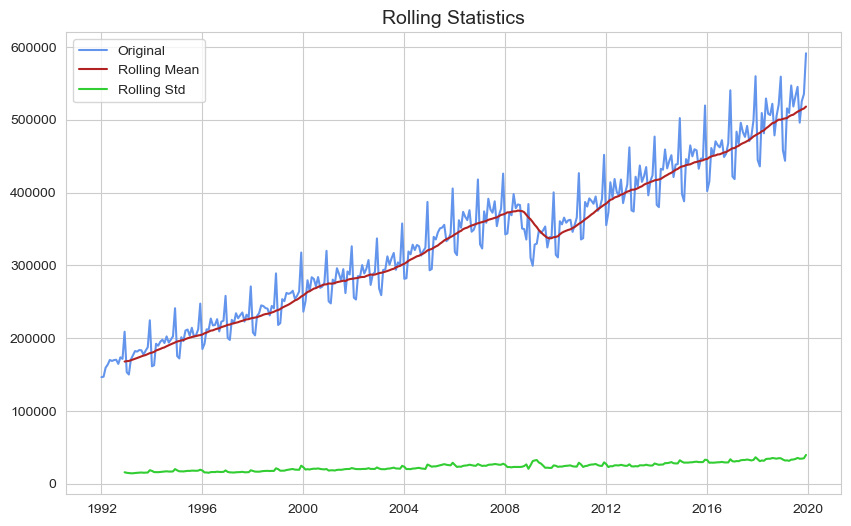

ADF Statistic: 0.224
p-value: 0.974
##################################
Critical Values:
1%: -3.451
5%: -2.871
10%: -2.572
##################################
Critical Values:
ADF > Critical Values
Failed to reject null hypothesis, time series is non-stationary.


In [9]:
def adfuller_test(ts, window = 12):
    
    movingAverage = ts.rolling(window).mean()
    movingSTD = ts.rolling(window).std()
    
    plt.figure(figsize = (10,6))
    orig = plt.plot(ts, color='cornflowerblue',
                    label='Original')
    mean = plt.plot(movingAverage, color='firebrick',
                    label='Rolling Mean')
    std = plt.plot(movingSTD, color='limegreen',
                   label='Rolling Std')
    plt.legend(loc = 'upper left')
    plt.title('Rolling Statistics', size = 14)
    plt.show(block=False)
    
    adf = adfuller(ts, autolag='AIC')
    
    print('ADF Statistic: {}'.format(round(adf[0],3)))
    print('p-value: {}'.format(round(adf[1],3)))
    print("##################################")  
    print('Critical Values:')
    
    for key, ts in adf[4].items():
         print('{}: {}'.format(key, round(ts,3)))
    print("##################################")
    
    print('Critical Values:')
    
    if adf[0] > adf[4]["5%"]:
        print("ADF > Critical Values")
        print ("Failed to reject null hypothesis, time series is non-stationary.")
    else:
        print("ADF < Critical Values")
        print ("Reject null hypothesis, time series is stationary.")
        
adfuller_test(df, window = 12) 

The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values.

Clearly, there is no reason to reject the null hypothesis. So, the time series is in fact non-stationary.

### Converting Data to Stationary

#### Logarithmic Transformation with Box-Cox

The Box-Cox transform is a configurable data transform method that supports both square root and log transform, as well as a suite of related transforms.

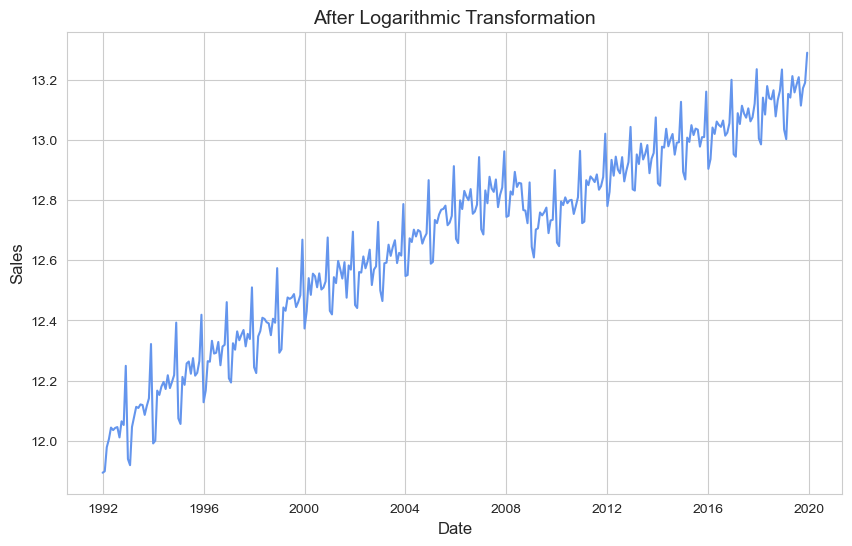

In [10]:
df_log_scaled = df
df_log_scaled['Sales'] = boxcox(df_log_scaled['Sales'], lmbda=0.0)
plt.figure(figsize = (10,6))
plt.plot(df_log_scaled, color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Sales', size = 12)
plt.title("After Logarithmic Transformation", size = 14)
plt.show()

### Removing Trend with Moving Average

A time series with a trend is called non-stationary.

An identified trend can be modeled. Once modeled, it can be removed from the time series dataset. This is called detrending the time series.

If a dataset does not have a trend or we successfully remove the trend, the dataset is said to be trend stationary.

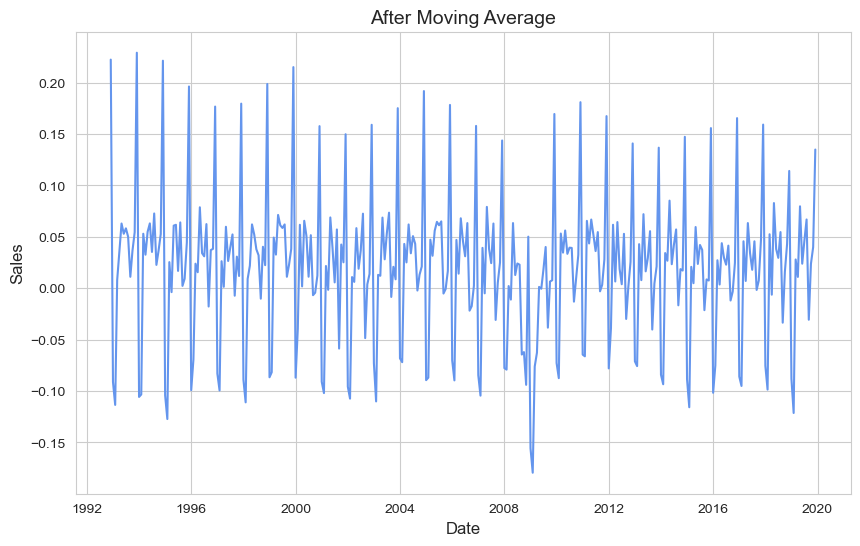

In [11]:
moving_avg = df_log_scaled.rolling(window=12).mean()
df_log_scaled_ma = df_log_scaled - moving_avg
df_log_scaled_ma.dropna(inplace=True)
plt.figure(figsize = (10,6))
plt.plot(df_log_scaled_ma, color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Sales', size = 12)
plt.title("After Moving Average", size = 14)
plt.show()

### Exponential Decay Transformation

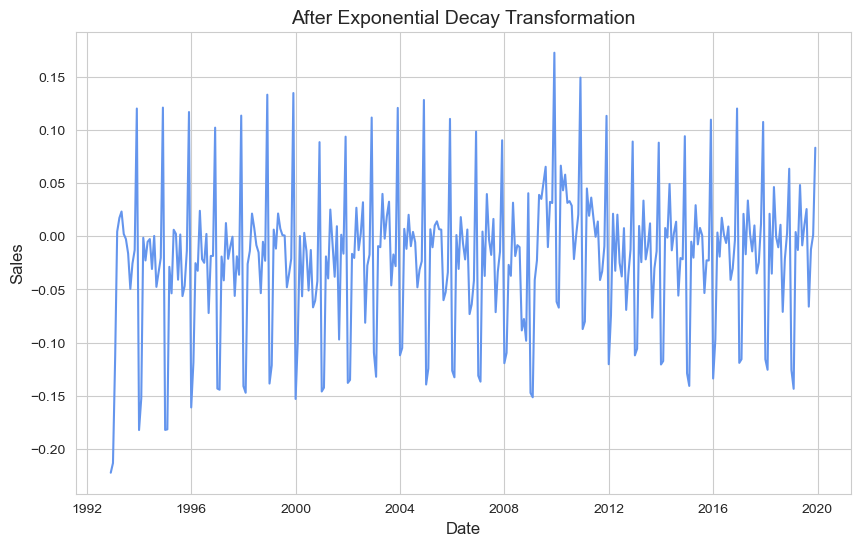

In [12]:
df_log_scaled_ma_ed = df_log_scaled_ma.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_lsma_sub_df_lsma_ed = df_log_scaled_ma - df_log_scaled_ma_ed
plt.figure(figsize = (10,6))
plt.plot(df_lsma_sub_df_lsma_ed - df_log_scaled_ma_ed, color='cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Sales', size = 12)
plt.title("After Exponential Decay Transformation", size = 14)
plt.show()

Let's test stationarity again.

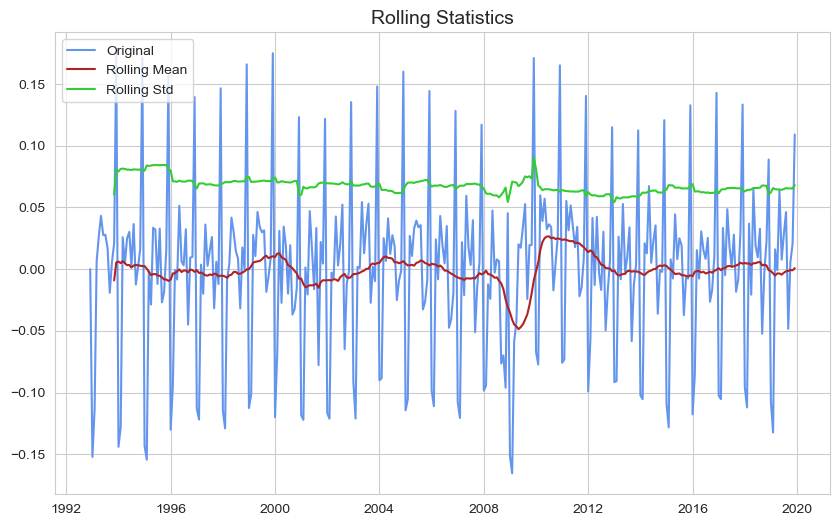

ADF Statistic: -4.957
p-value: 0.0
##################################
Critical Values:
1%: -3.452
5%: -2.871
10%: -2.572
##################################
Critical Values:
ADF < Critical Values
Reject null hypothesis, time series is stationary.


In [13]:
adfuller_test(df_lsma_sub_df_lsma_ed, window = 12)

The p-value is very less than the significance level of 0.05 and hence we can reject the null hypothesis and take that the series is stationary.

### Decomposition

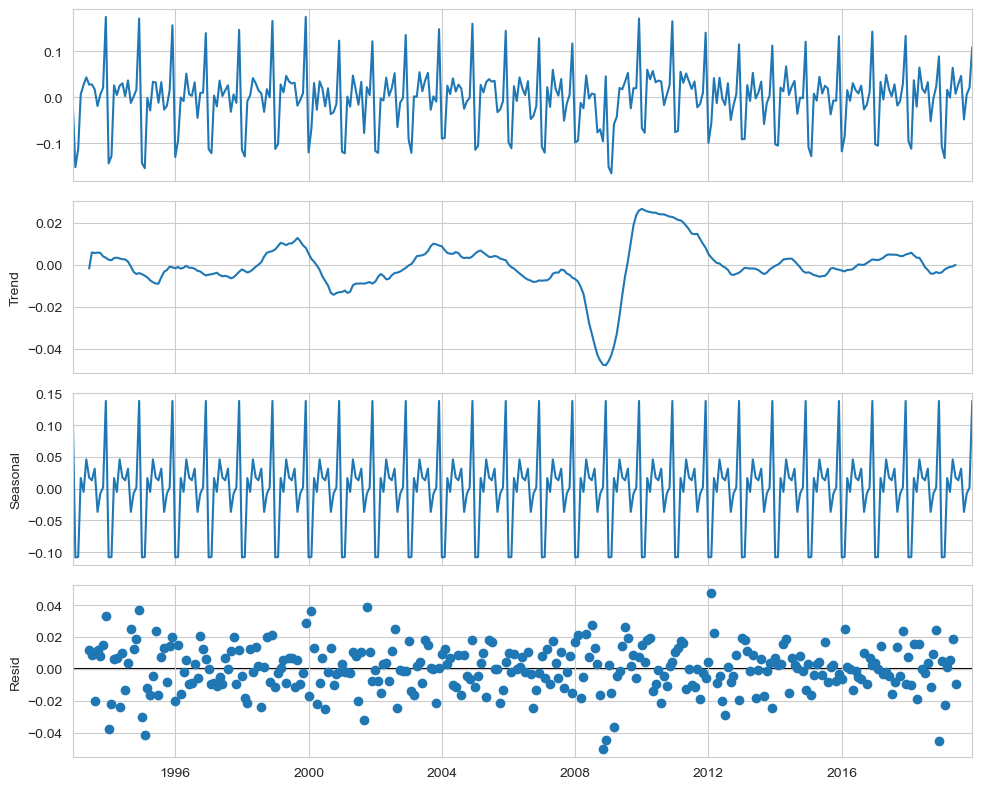

In [14]:
rcParams['figure.figsize']=10,8
df_seasonal_decompose = seasonal_decompose(df_lsma_sub_df_lsma_ed, 
                                           model='duplicative')
df_seasonal_decompose.plot()
plt.show()

### ACF & PACF

Autocorrelation and partial autocorrelation plots are heavily used in time series analysis and forecasting.

These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps.

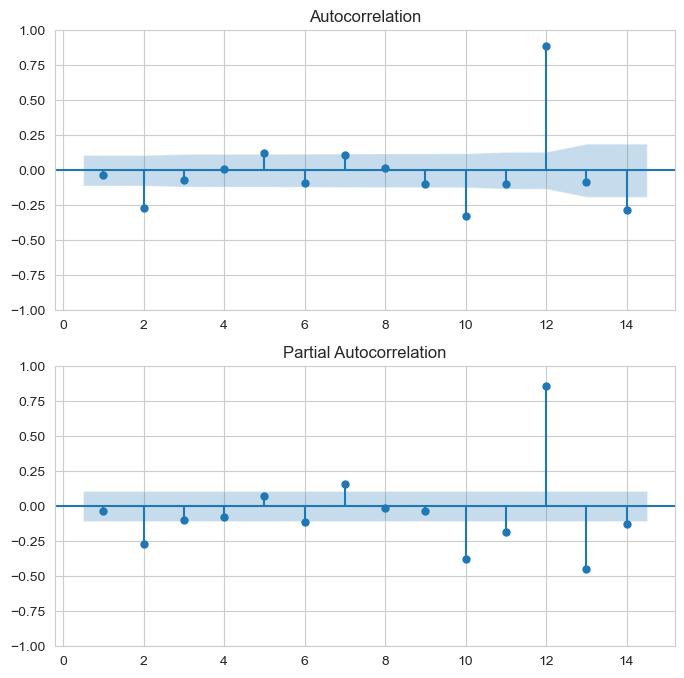

In [15]:
fig, (ax1, ax2)=plt.subplots(2,1,figsize=(8,8))

plot_acf(df_lsma_sub_df_lsma_ed,lags=14, zero=False, ax=ax1)
plot_pacf(df_lsma_sub_df_lsma_ed,lags=14, zero=False, ax=ax2)
plt.show()

### Auto ARIMA

In [16]:
results=pm.auto_arima(df_lsma_sub_df_lsma_ed, d=1, start_p=0, start_q=0, max_p=3, max_q=3,
                    seasonal=True, m=12, D=1, start_P=0, start_Q=0, max_P=3, max_Q=3, information_criterion='aic', trace=True, error_action='ignore', stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-1410.438, Time=0.31 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-1466.408, Time=0.50 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-1550.098, Time=0.73 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-1474.958, Time=0.41 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-1559.261, Time=2.60 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-1485.704, Time=1.36 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-1578.787, Time=3.77 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-1512.662, Time=1.75 sec
 ARIMA(0,1,1)(3,1,1)[12]             : AIC=-1589.727, Time=10.96 sec
 ARIMA(0,1,1)(3,1,0)[12]             : AIC=-1548.312, Time=2.93 sec
 ARIMA(0,1,1)(3,1,2)[12]             : AIC=-1589.142, Time=5.61 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=-1570.077, Time=1.60 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=-1554.189, Time=5.58 sec
 ARIMA(1,1,1)(3,1,1)[12]             : AIC=-1584.461, Time=3.63 sec
 ARI

In [17]:
model=SARIMAX(df_lsma_sub_df_lsma_ed,order=(0,1,1),  seasonal_order=(3, 1, 1, 12))
results=model.fit()

In [18]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                  325
Model:             SARIMAX(0, 1, 1)x(3, 1, 1, 12)   Log Likelihood                 800.864
Date:                            Tue, 11 Jul 2023   AIC                          -1589.727
Time:                                    14:32:30   BIC                          -1567.269
Sample:                                12-01-1992   HQIC                         -1580.752
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4109      0.040    -10.356      0.000      -0.489      -0.333
ar.S.L12       0.0348      0.097      0.358      0.721      -0.156       0.226
ar.S.L24      -0.3638      0.055     -6.608      0.000      -0.472      -0.256
ar.S.L36      -0.3129      0.066     -4.721      0.000      -0.443      -0.183
ma.S.L12      -0.6575      0.087     -7.523      0.000      -0.829      -0.486
sigma2         0.0003   1.92e-05     16.825      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.60   Jarque-Bera (JB):               429.80
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                            -1.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

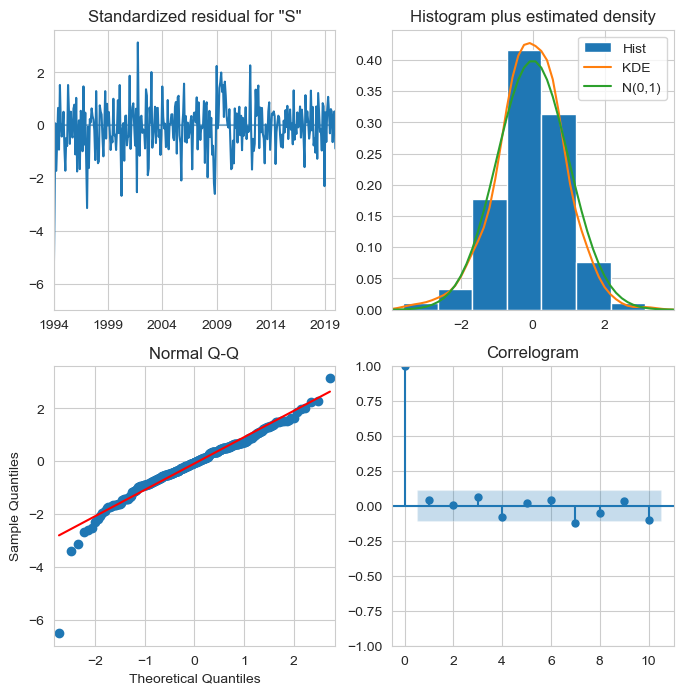

In [19]:
results.plot_diagnostics(figsize=(8,8))
plt.show()

All the 4 plots indicates a good fit of the SARIMA model on the given time serie.

### SARIMA Prediction

Create a vector that will host the predictions

In [20]:
prediction = results.get_prediction(start=-24)
mean_prediction=prediction.predicted_mean
mean_prediction = mean_prediction.rename("prediction")

Get the confidence intervals from the sarima prediction

In [21]:
confi_int_p=prediction.conf_int()
lower_limits_p=confi_int_p.iloc[:,0]
upper_limits_p=confi_int_p.iloc[:,1]

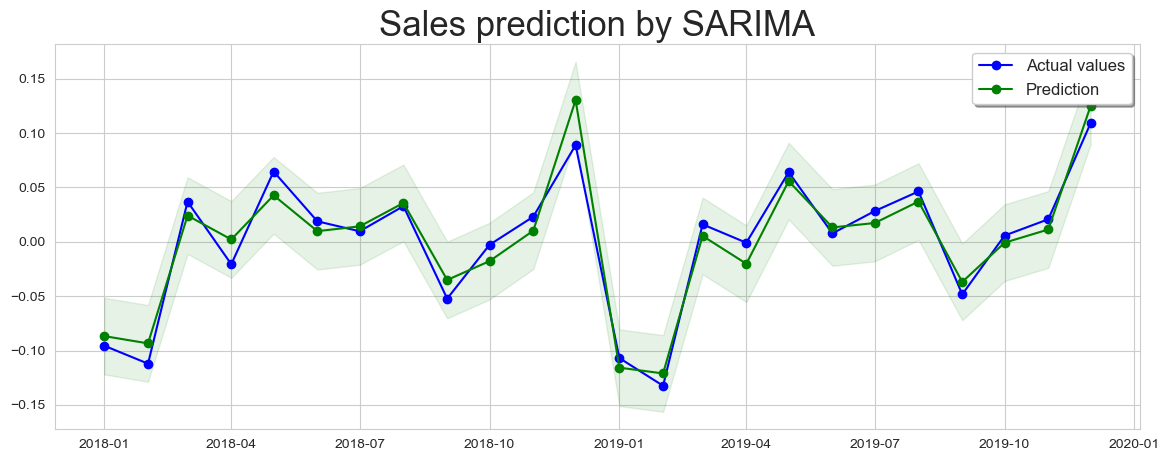

In [22]:
plt.figure(figsize=(14,5))
plt.title("Sales prediction by SARIMA", fontsize=25)

plt.plot(df_lsma_sub_df_lsma_ed[-24:].index,df_lsma_sub_df_lsma_ed[-24:].values, label='Actual values', color="blue", marker="o")

plt.plot(mean_prediction[-24:].index, mean_prediction[-24:].values,label='Prediction', color="green", marker="o")
plt.fill_between(mean_prediction[-24:].index, lower_limits_p, upper_limits_p, alpha=0.1, color="green")

plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.show()

In [23]:
mape_sarima = mean_absolute_percentage_error(df_lsma_sub_df_lsma_ed.iloc[-24:,0],mean_prediction)
print(f"MAPE OF SARIMA MODEL : {mape_sarima:.2f} %")

MAPE OF SARIMA MODEL : 1.46 %


In [24]:
rmse_sarima = sqrt(mean_squared_error(df_lsma_sub_df_lsma_ed[-24:].values,mean_prediction.values))
print(f"RMSE OF SARIMA MODEL : {rmse_sarima:.2f} ")

RMSE OF SARIMA MODEL : 0.02 


### SARIMA Forecast

In [25]:
forecast = results.get_forecast(steps=12)
mean_forecast=forecast.predicted_mean
mean_forecast = mean_forecast.rename("prediction")

In [26]:
confi_int_f=forecast.conf_int()
lower_limits_f=confi_int_f.iloc[:,0]
upper_limits_f=confi_int_f.iloc[:,1]

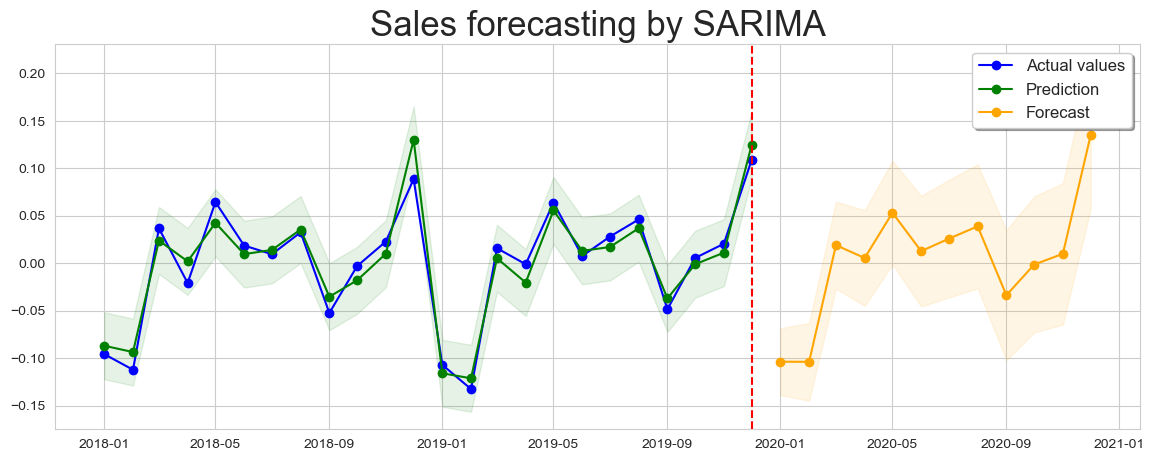

In [27]:
plt.figure(figsize=(14,5))
plt.title("Sales forecasting by SARIMA", fontsize=25)

plt.plot(df_lsma_sub_df_lsma_ed[-24:].index,df_lsma_sub_df_lsma_ed[-24:].values, label='Actual values', color="blue", marker="o")

plt.plot(mean_prediction[-24:].index, mean_prediction[-24:].values,label='Prediction', color="green", marker="o")
plt.fill_between(mean_prediction[-24:].index, lower_limits_p, upper_limits_p, alpha=0.1, color="green")

plt.plot(mean_forecast[-24:].index,mean_forecast[-24:].values, label='Forecast', color="orange", marker="o")
plt.fill_between(mean_forecast[-24:].index, lower_limits_f, upper_limits_f, alpha=0.1, color="orange")
plt.axvline(df_lsma_sub_df_lsma_ed.index[-1], color="red", linestyle="--")
plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.show()